In [1]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
ray.init()

2020-11-20 17:28:46,363	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:6379',
 'object_store_address': '/tmp/ray/session_2020-11-20_17-28-45_345280_2114759/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-20_17-28-45_345280_2114759/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-20_17-28-45_345280_2114759',
 'metrics_export_port': 54351,
 'node_id': 'ba5b8621a427017b7ddfafc16709b6db343a6d45'}

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [2]:
# import data from DNN training
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [3]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 10000 + 1
L = 2

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00015

r_m = np.zeros(theta_m_1.shape[0])

tau_start = theta_m_1[q-1]

In [4]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

In [5]:
@ray.remote
def delta_beta(z, S, B_zeta, Lambda, beta):
    return ((z*(1/S).T).dot(B_zeta) - (beta.T).dot(B_zeta.T).dot(B_zeta) + np.sum(((1/Lambda)**2)*beta))
@ray.remote
def delta_1_log_tau(p, log_tau, Lambda):
    tau = np.exp(log_tau)
    tau2 = tau**2
    Lambda2 = Lambda**2
    return(- (p-1) - (2*tau2)/(1+tau2) + 2*np.sum((Lambda2/tau2)/(1+Lambda2/(tau2))))

def generate_dS2_ddS2_S2_S(Lambda, BoB):
    
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    Lambda2 = Lambda**2
    
    dS2, ddS2 = np.zeros((n,p)), np.zeros((n,p))
    for lj in range(0, p):
        dS2[:,lj] = - BoB[:,lj]*Lambda2[lj]/((1+W)**2)
        ddS2[:,lj] = (-BoB[:,lj]*Lambda2[lj] + (BoB[:,lj]*(Lambda2[lj]**2)))/((1+W)**3)
    
    return(dS2, ddS2, S2, S)

@ray.remote
def delta_1_lambda(Lambda, beta, B_zeta, dS2, ddS2, S2, S, z, tau):
    p = len(Lambda)
    Lambda2 = Lambda**2
    tau2 = tau**2
    dlogFucj = np.zeros(p)
    for lj in range(0,p):
        dlogFucj[lj] = 0.5*(beta[lj]**2)/Lambda2[lj] - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2) - 0.5*np.sum(dS2[:,lj]/S2) - 0.5*np.sum((z*z*(-dS2[:,lj]/(S2**2)))) + np.sum( beta.dot(B_zeta.T).dot(np.diag(-0.5*(dS2[:,lj]/(S2**(1.5))))).dot(z))  
    #dlogFucj = (0.5*(beta**2)/Lambda2 - (Lambda2/tau2)/(1 + Lambda2/tau2) - 0.5*np.sum(dS2/(np.tile(S2.T, [p,1]).T), axis = 0) - 
    #           0.5*np.sum((np.tile(z*z, [p,1]).T*(-dS2/np.tile((S2**2), [p,1]).T)), axis = 0) + 
    #           (beta*((B_zeta*(-0.5)*(dS2/np.tile(S2**1.5, [p,1]).T)).T).dot(z)))
    return(dlogFucj)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, BoB):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    Lambda_t = np.exp(0.5*vartheta_new[p:2*p])
    log_tau_t = vartheta_new[2*p]

    dS2, ddS2, S2, S = generate_dS2_ddS2_S2_S(Lambda_t, BoB)
    
    # Gradient w.r.t. beta
    #grad_beta = delta_beta(z, S, B, Lambda_t, beta_t)
    
    #grad_lambda = delta_1_lambda(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    # Gradient w.r.t. tau
    #grad_tau = delta_1_log_tau(p, log_tau_t, Lambda_t)
    
    ret_id1 = delta_beta.remote(z, S, B, Lambda_t, beta_t)
    ret_id2 = delta_1_lambda.remote(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    ret_id3 = delta_1_log_tau.remote(p, log_tau_t, Lambda_t)
    grad_beta, grad_lambda, grad_tau = ray.get([ret_id1, ret_id2, ret_id3])
    #print(grad_beta, grad_lambda, grad_tau)
    
    return(np.append(grad_beta, np.append(grad_lambda, grad_tau)))

# wrong log density!!!!
'''def log_density(z, u,  beta, B, p,  n, S, S2, tBB, theta, betaBt):   
    return (- 0.5*np.sum(np.log(S2))- 0.5*z.dot((1/S2)*z)+ 
            betaBt.dot(z*(1/S)) - 
            0.5*beta.T.dot(tBB).dot(beta) - 
            0.5/np.exp(u)*np.sum(beta**2) - 
            0.5*u*(p-1)  - np.sqrt(np.exp(u)/theta))'''

def log_density(S, B, beta, Lambda, log_tau, z, p):
    Lambda2 = Lambda**2
    tau2 = np.exp(log_tau)**2
    S2 = S**2
    term1 = - 0.5*np.sum(np.log(S2))
    term2 = -0.5*np.sum(((z - S*(B.dot(beta)))**2)*(1/S2))
    term3 = + 0.5*np.sum(Lambda2)
    term4 = -0.5*np.sum((beta**2)/(Lambda2))
    term5 = -(p-1)*log_tau
    term6 = - np.sum(np.log(1+Lambda2/tau2))
    term7 = - np.log(1 + tau2)
    return(term1 + term2 + term3 + term4 + term5 + term6 + term7)

In [6]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt):
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r_tilde).reshape(2*p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, BoB)
    
    # update momentum again
    r_tilde = r_tilde + (epsilon/2)*Delta_theta_tilde
    
    return(theta_tilde, r_tilde)

In [7]:
seed = 123
r0 = np.repeat(None, M)
theta_tilde = np.repeat(None, M)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(1,p), 0))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.zeros(21)
r_tilde[0] = np.zeros(21)
theta_m_1[1] = np.zeros(21)
all_thetas = []
theta_m_1[0] = np.zeros(21)
r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
for m in tqdm(range(1, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = theta_m_1[m].reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt)
    
    dS2, ddS2, S2, S = generate_dS2_ddS2_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    #log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    #alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
        # probability that proposal is accepted
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1):
        print(np.mean(acc[-100:]))
    

  0%|          | 14/10000 [1:36:25<1146:12:42, 413.21s/it]


KeyboardInterrupt: 

In [ ]:
#np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_L1000.npy', np.array(all_thetas))

In [ ]:
#all_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy')

(-1.0, 1.0)

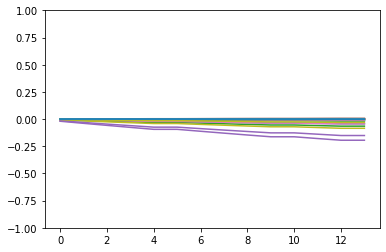

In [8]:
import matplotlib.pyplot as plt
plt.plot(all_thetas[0:100])
plt.ylim(-1,1)

In [13]:
all_thetas[12]

array([-4.29350751e-02,  1.25710581e-04, -6.50293959e-02, -5.81747516e-05,
       -1.94629333e-01,  6.75803158e-03, -4.41408110e-02, -2.53452936e-03,
       -8.46504903e-02, -1.26878398e-02, -7.67320990e-03,  8.07028609e-05,
       -1.76016997e-02, -9.99787350e-05, -1.51206989e-01,  3.35455181e-04,
       -8.30156545e-03, -5.58718809e-04, -3.11340847e-02, -1.00406447e-03,
       -1.51626247e-04])

In [ ]:
np.mean(acc)

In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.plot(df[:,10])

In [ ]:
all_thetas[93][10:21]

In [ ]:
theta_hmc = np.mean(all_thetas[20:], axis = 0)
theta_hmc_sd = np.std(all_thetas[20:], axis = 0)
#np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', np.array(all_taus[J[1]:]))

In [ ]:
theta_hmc

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')

In [ ]:
vartheta_bts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy')
vartheta_dts = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy')

In [ ]:
B_ts = np.mean(vartheta_bts[10000:, :,:], axis = 0)
d_ts = np.mean(vartheta_dts[10000:, :,:], axis = 0)
va_sd = np.sqrt(np.diag(B_ts.dot(B_ts.T) + d_ts**2))

In [ ]:
theta_va = np.mean(vartheta_va[10000:, :,:], axis = 0)

In [ ]:
theta_va

In [ ]:
plt.scatter(theta_hmc[0:10], theta_va[0:10])
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
beta_va.shape

In [ ]:
plt.scatter(va_sd, theta_hmc_sd)
ident = [0, 1.0]
plt.plot(ident,ident)